<h1><center><strong><font color="chillipepper">Task Specific Modeling: Sequence Classification with and without Context</font></strong></center></h1>
<h3><center><font color="green"><strong>Correction 💯</strong></font></center></h3>

In [2]:
import torch
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter

## <font color="chillipepper">What about BERT?</font>

You can find a tutorial on finetuning here : https://huggingface.co/docs/transformers/training

And look at the following code cells which modify the model you used to exploit BERT pretrained vectors and finetune them.

We consider `bert-tiny`to have a very small version of BERT (so the finetuning is faster), this renders the results less viable. To finetune the real `bert-base-cased` with all the training samples would take a lot of time.

In [ ]:
tweet_eval = load_dataset('tweet_eval', 'emoji')
def adjust_labels(entries):
  res = {}
  res['text'] = entries['text']
  res['label'] = [ label - 1 for label in entries['label']]
  return res

for split in ['train', 'validation', 'test']:
  rows_to_select = [ i for i, entry in enumerate(tweet_eval[split]) if entry['label'] <= 3 and entry['label'] != 0 ]
  tweet_eval[split] = tweet_eval[split].select(rows_to_select)
  tweet_eval[split] = tweet_eval[split].map(lambda e: adjust_labels(e)  , batched=True)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = tweet_eval.map(tokenize_function, batched=True)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(200))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [ ]:
from transformers import AutoModelForSequenceClassification
# This model is equal to BERT + a linear layer for classification. In our custom model we designed a FastText + a hidden layer and linear layer for classification
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=3)

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")
model.eval()
preds, trues = [], []
for i, batch in tqdm(enumerate(eval_dataloader), desc="evaluating", total=eval_dataloader.__len__()):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

    _, tag_seq  = torch.max(logits, 1)
    preds.extend(tag_seq.cpu().detach().tolist())
    trues.extend(batch['labels'].cpu().detach().tolist())

metric.compute()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

# <font color="chillipepper">**Sequence Classification with Conversational Context** </font>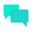 -> 💬 -> `__dummy__`, `inform`, `question`, `directive`, `commissive`

For this task we will use a dataset made of dialogs. This adds a new level to the classification task, each message being a part of a sequence (the conversation).

In this lab, we only consider the dialog acts. Here is the dialog acts indice mapping:
`__dummy__` (0), `inform` (1), `question` (2), `directive` (3), `commissive` (4).

```
This example was too long and was cropped:
{
    "act": [2, 1, 1, 1, 1, 2, 3, 2, 3, 4],
    "dialog": "[\"Good afternoon . This is Michelle Li speaking , calling on behalf of IBA . Is Mr Meng available at all ? \", \" This is Mr Meng ..."
}
```


| name  |train|validation|test|
|-------|----:|---------:|---:|
|default|11118|      1000|1000|

Links:
- https://huggingface.co/datasets/daily_dialog

Once again we consider the data handling.

In [ ]:
dailydialog = load_dataset('daily_dialog')

In [ ]:
dailydialog

In [ ]:
entry = dailydialog['train'][0]
entry

## <font color="chillipepper">Data Handling</font>

#### 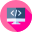 **TODO! Adapt the data handling**

Complete the following code by taking into account the hierarchical level:
- conversation
  - message -> act

In [ ]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm
import numpy as np

tok = TweetTokenizer()

def tokenize_pad_numericalize_dialog(entry, vocab_stoi, max_length=20):
  ''' message level '''
  dialog = [ [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(e.lower()) ] 
          for e in entry ]
  padded_dialog = list()
  for d in dialog:
    if len(d) < max_length:    padded_dialog.append( d + [ vocab_stoi['<pad>'] for i in range(len(d), max_length) ] )
    elif len(d) > max_length:  padded_dialog.append(d[:max_length])
    else:                      padded_dialog.append(d) 
  return padded_dialog

def tokenize_all_dialog(entries, vocab_stoi, max_message_length=20, max_dialog_length=12):
  ''' dialog level '''
  pad_message = [ vocab_stoi['<pad>'] ]
  pad_label = [0] # because 0 means dummy in dialog acts mapping
  res_dialog, res_labels = [], []

  for entry in entries['dialog']:
    text  = tokenize_pad_numericalize_dialog(entry, vocab_stoi)
    if len(text) < max_dialog_length:    text = text + [ [vocab_stoi['<pad>']] * max_message_length for i in range(len(text), max_dialog_length)]   # pad_message * (max_dialog_length - len(text))
    elif len(text) > max_dialog_length:  text = text[-max_dialog_length:] # keeps the last n messages
    res_dialog.append(text)

  for labels in entries['act']:
    if len(labels) < max_dialog_length:   labels = labels + [ 0 for i in range(len(labels), max_dialog_length) ]          # pad_label * (max_dialog_length - len(labels))
    elif len(labels) > max_dialog_length: labels = labels[-max_dialog_length:]
    res_labels.append(labels)

  res = {'text': res_dialog, 'label': res_labels}
  return res

vocab_stoi = pretrained_vocab.get_stoi()

for split in ['train', 'validation', 'test']:
  dailydialog[split] = dailydialog[split].map(lambda e: tokenize_all_dialog(e, vocab_stoi), batched=True)

In [ ]:
dailydialog

The dataset class is the same. But we could put the data handling in the Dataset class. To keep it simple, we separate both processes.

In [ ]:
from torch.utils.data import Dataset
import numpy as np

class DialogActDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      return item

In [ ]:
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(DialogActDataset(dailydialog['train'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(DialogActDataset(dailydialog['validation'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(DialogActDataset(dailydialog['test'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
next(iter(train_loader))['text'].shape

## <font color="chillipepper">Create the Model dedicated to conversations</font>

First, please find here a custom layer which will only compute the average of the embeddings for a message. You will need it later on and it serves to show how to integrate custom models, inside a model.

In [ ]:
import torch.nn as nn
class SimpleAvgConvEBD(nn.Module):
    '''
        An aggregation method that encodes every document by its average word
        embeddings.
    '''
    def __init__(self, ebd, args, avg_global=False):
        super(SimpleAvgConvEBD, self).__init__()

        # self.ebd = ebd
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors.vectors, freeze=True)

        self.avg_global = avg_global


    def forward(self, data):
        '''
            @param data dictionary
                @key text: batch_size * max_text_len
            @return output: batch_size * embedding_dim
        '''
        ebd = self.ebd(data)

        # count length excluding <pad> and <unk>.
        is_zero = (torch.sum(torch.abs(ebd), dim=3) > 1e-8).float() 
        soft_len = torch.sum(is_zero, dim=2, keepdim=True)

        soft_len[soft_len < 1] = 1

        # # don't need to mask out the <pad> tokens, as the embeddings are zero
        ebd = torch.sum(ebd, dim=2) # dim = 2
        ebd = ebd / soft_len

        # avg_global allows two usages for this model
        if self.avg_global:
            ebd = torch.mean(ebd, 2)
        return ebd

#### 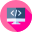 **TODO! Adapt the model**

**Complete the following code** to adapt the model to consider the two levels and the conversational context with biddirectional LSTMs.

Please look into the model and se the differences, here we actually compute the loss in the forward pass. It is up to your preference to do so.

Docs:
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
- https://pytorch.org/docs/stable/nn.html

In [ ]:
import torch
# this import contains multiple CLASSES to use (hence you need to instanciate it). Usually different layer types
import torch.nn as nn
# this import contains multiple FUNCTIONS to use (hence no need to instanciate it)
import torch.nn.functional as F


# create the class by inheriting the PyTorch Module
class BiLSTM(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, args, dimension=300, freeze_embeddings = False):
        '''
        construtor of the class (function automatically used when creating a new instance of this class)
        '''
        super(BiLSTM, self).__init__()

        # put args as a class variable
        self.args = args
        # create the embedding layer from the pretrained vectors
        self.embedding = nn.Embedding.from_pretrained(pretrained_vectors.vectors, freeze=freeze_embeddings)

        # instanciate the SimpleAvgConvEBD class, dedicate to average the utterances
        self.utterance_ebd = SimpleAvgConvEBD(None, {}, avg_global=False)
        # put the SimpleAvgConvEBD instance into the device (cpu or gpu), depending on the arguments
        if self.args['cuda'] != -1: self.utterance_ebd.cuda(args['cuda'])

        # put dimension as a class variable
        self.dimension = dimension

        # instanciate the LSTM class from PyTorch. Dimensions are divided by 2 due to bidirectional being True
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension//2, 
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        # instanciate a dropout layer with 0.5. This means, we will ignore (put to zeros) half (0.5) of the data to prevent the model from overfitting
        self.drop = nn.Dropout(p=0.5)

        # instanciate a linear layer with an output size equal to the number of classes. This means this will be used to apply a criterion to compute the predictions.
        self.hidden2tag = nn.Linear(dimension, num_class)

    def forward(self, data, text_len=12):
        '''
        The forward function. Used to apply the model (during training or inference).
        '''
        # # use the function previously defined, in order to put the data values in the GPU is said so in the args
        # data = batch_to_cuda(data, self.args['cuda'])
        # # keep the device in a variable in order to prevent further mistakes
        # device = data['text'].device

        # use the utterance average embeddings to transform the data['text'] into a representation of conversation with a vector per utterance 
        text_emb = self.utterance_ebd(data['text'])

        # apply the LSTM and retrieve the output, and the hidden vector. Hidden vector is not used afterwards. It would be useful in case of another type of LSTM for instance
        output, hidden = self.lstm(text_emb)

        # apply the dropout layer (ignore 50% of the data)
        output = self.drop(output)

        # apply the linear layer to have class logits
        outputs = self.hidden2tag(output)

        # keep some dimension infos as variable for convenience
        batch_size = outputs.size(0)
        seq_len = outputs.size(1)

        # modify the outputs representation to prepare score computation
        outputs = outputs.view(batch_size*seq_len, -1)
        # apply a softmax on the outputs to obtain probabilities
        scores = F.log_softmax(outputs, 1)

        # get the predicted tags using the maximum probability from the softmax
        _, tag_seq  = torch.max(scores, 1)
        # reshape the predicted tags to follow the batch and sequence length
        tag_seq = tag_seq.view(batch_size, seq_len)

        # some example of manual class weights
        # weights = torch.Tensor([0.1, 1, 1, 1, 1, 1, 1]).to(device)

        
        if 'class_weights' in self.args:
          # class weights from args if there is any. It should be a torch tensor, but we move it to the dedicated device
          # we use class weights to influence the Negative Log Likelihood. Influencing in the same time the backpropagation and, thus, the update of the model
          loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(device))  
        else: 
          # if not 'class_weights' key in the args dict(), we use the Negative Log Likelihood as is
          loss_fn = nn.NLLLoss()

        # apply the loss function (Softmax + NLLLoss = Cross Entropy)
        loss = loss_fn(scores, data['label'].view(batch_size*seq_len))

        # we return 3 elements as a tuple : the loss, the softmax outputs, and the predicted tag set already in a good format
        return loss, scores, tag_seq

In [ ]:
def train(model, optimizer, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    # put parameters of the model and the optimizer to zero before doing another iteration
    optimizer.zero_grad()
    model.zero_grad()

    # apply the model on the batch
    loss, logits, tag_seq = model(batch)
    # compute gradient values
    loss.backward()
    # indicate to the optimizer we've done a step
    optimizer.step()
    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))


In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """
  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():
      # apply the model
      loss, logits, tag_seq = model(batch)
      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

## <font color="chillipepper">Start Training 📉</font>

In [ ]:
import torch.optim as optim

def run_epochs(model, args):

  if args['cuda'] != -1:
      model.cuda(args['cuda'])
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      args['device'] = device
      print("device set to %s" % (device) )

  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [ ]:
# here you can specify if you want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If you only have one GPU, put 0.
args.update({'max_eps': 10, 'lr': 0.001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 5})

# Instantiate model with pre-trained fasttext vectors
# Here we set the dimension to 50 to make it faster and we only consider a small conversation length (12)
model = BiLSTM(pretrained_vectors.vectors, args['num_class'], args, dimension=50, freeze_embeddings = True )
loss_list_val = run_epochs(model, args)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

In [ ]:
# let's call our function using the list of validation losses to show the plot
plot_loss(loss_list_val)

## <font color="chillipepper">Evaluate the Model 📊</font>

#### 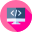 **TODO! Evaluate it**

**Do all the evaluation**: 
- predict on testset
- classification report
- confusion matrix

In [ ]:
# let's use our model for inference on the test set. We can short it by naming it "test our model"
# we set the target as "test" to print the correct info, and use the test loader
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, model)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
names.remove('__dummy__') # dummy label is not interesting
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
names = ['__dummy__', 'inform', 'question', 'directive', 'commissive']
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()